In [60]:
import tensorflow as tf
import os
import cv2
import imghdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from itertools import chain

In [61]:
train = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_train_v2.csv')
test = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_validation_v2.csv')
train_img_dir = '/kaggle/input/handwriting-recognition/train_v2/train'
test_img_dir = '/kaggle/input/handwriting-recognition/validation_v2/validation'

In [62]:
testing = pd.read_csv('/kaggle/input/handwriting-recognition/written_name_test_v2.csv')
testing_img_dir = '/kaggle/input/handwriting-recognition/test_v2/test'

In [63]:
print("Tain set: ",train['IDENTITY'].shape[0])
print("UNREADABLE in train set : ", train['IDENTITY'].isnull().sum())
print("Test set: ", test['IDENTITY'].shape[0])
print("UNREADABLE in validation set : ", test['IDENTITY'].isnull().sum())

train = train[train['IDENTITY'] != 'UNREADABLE']
train = train.dropna()
test = test[test['IDENTITY'] != 'UNREADABLE']
test = test.dropna()
print("train:",train.shape[0]," test:",test.shape[0])

Tain set:  330961
UNREADABLE in train set :  565
Test set:  41370
UNREADABLE in validation set :  78
train: 330294  test: 41280


In [64]:
testing = testing[testing['IDENTITY'] != 'UNREADABLE']
testing = testing.dropna()

In [65]:
def to_binary(image):
    image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),dsize=(284,62))
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (thresh, image_binary) = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    image_binary = cv2.threshold(image_gray, thresh, 255, cv2.THRESH_BINARY)[1]
    image_binary = image_binary / 255
    return image_binary

In [66]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from functools import partial

def process_single_image(args):
    """Process a single image and return image and identity
    
    Args:
        args: tuple of (image_filename, train_img_dir, to_binary_func)
    """
    image_filename, train_img_dir, to_binary = args
    image_path = os.path.join(train_img_dir, image_filename)
    image = cv2.imread(image_path)
    return to_binary(image)

def load_images_parallel(train_df, train_img_dir, to_binary, batch_size=1000, num_workers=4):
    """
    Load and process images in parallel using batches
    
    Args:
        train_df: DataFrame containing image information
        train_img_dir: Directory containing images
        to_binary: Function to convert image to binary
        batch_size: Number of images to process in each batch
        num_workers: Number of parallel workers
    """
    total_images = len(train_df)
    
    # Get sample image to determine shape
    sample_args = (train_df['FILENAME'].iloc[0], train_img_dir, to_binary)
    sample_image = process_single_image(sample_args)
    
    # Pre-allocate arrays
    images = np.zeros((total_images, *sample_image.shape), dtype=sample_image.dtype)
    identities = np.array(train_df['IDENTITY'])
    
    # Create list of arguments for parallel processing
    process_args = [
        (filename, train_img_dir, to_binary)
        for filename in train_df['FILENAME']
    ]
    
    # Process images in batches using ThreadPoolExecutor
    for batch_start in range(0, total_images, batch_size):
        batch_end = min(batch_start + batch_size, total_images)
        batch_args = process_args[batch_start:batch_end]
        
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            batch_results = list(executor.map(process_single_image, batch_args))
            
        # Store results in pre-allocated array
        for idx, result in enumerate(batch_results):
            images[batch_start + idx] = result
            
        # Optional: Print progress
        print(f"Processed {batch_end}/{total_images} images")
    
    return images, identities

# Load images with optimized function
train_data_img, train_data_idt = load_images_parallel(
    train_df=train[:10000],
    train_img_dir=train_img_dir,
    to_binary=to_binary,
    batch_size=1000,
    num_workers=4
)


Processed 1000/10000 images
Processed 2000/10000 images
Processed 3000/10000 images
Processed 4000/10000 images
Processed 5000/10000 images
Processed 6000/10000 images
Processed 7000/10000 images
Processed 8000/10000 images
Processed 9000/10000 images
Processed 10000/10000 images


In [67]:
test_data_img, test_data_idt = load_images_parallel(
    train_df=test[:10000],
    train_img_dir=test_img_dir,
    to_binary=to_binary,
    batch_size=1000,
    num_workers=4
)

Processed 1000/10000 images
Processed 2000/10000 images
Processed 3000/10000 images
Processed 4000/10000 images
Processed 5000/10000 images
Processed 6000/10000 images
Processed 7000/10000 images
Processed 8000/10000 images
Processed 9000/10000 images
Processed 10000/10000 images


In [68]:
testing_data_img, testing_data_idt = load_images_parallel(
    train_df=testing[:10000],
    train_img_dir=testing_img_dir,
    to_binary=to_binary,
    batch_size=1000,
    num_workers=4
)

Processed 1000/10000 images
Processed 2000/10000 images
Processed 3000/10000 images
Processed 4000/10000 images
Processed 5000/10000 images
Processed 6000/10000 images
Processed 7000/10000 images
Processed 8000/10000 images
Processed 9000/10000 images
Processed 10000/10000 images


In [69]:
all_data = train_data_idt + test_data_idt
# Concatenate names into a single string
all_characters = ''.join(all_data)

# Create a set to get unique characters
unique_characters_set = set(all_characters)

# Convert the set back to a list if needed
unique_characters_list = list(unique_characters_set)

In [70]:
lb = LabelBinarizer()
if "<UNK>" not in unique_characters_list:
    unique_characters_list.append("<UNK>")
lb.fit(unique_characters_list)

lb.classes_
dec = {}
for i in range(len(unique_characters_list)):
    if unique_characters_list[i] in dec.keys():
        pass
    else: 
        a = lb.transform([unique_characters_list[i]])
        a = list(chain(*a)) #flattened_list from [[....]] to []
        dec[unique_characters_list[i]]= a

for key in dec:
    print(key, end=' ')

M T Z P ' N O K X E - o V F G A Y C I   J U L H W R Q D S B s <UNK> 

In [71]:
print("train data longest word :")
length_of_longest_word_in_train = len(max(train_data_idt, key=len))
print(length_of_longest_word_in_train)
word_with_longest_characters = max(train_data_idt, key=len)
print(word_with_longest_characters)
print()
print("test data longest word :")
length_of_longest_word_in_test = len(max(test_data_idt, key=len))
print(length_of_longest_word_in_test)
word_with_longest_characters = max(test_data_idt, key=len)
print(word_with_longest_characters)

train data longest word :
24
DARE DE NAISSANCE CLASSE

test data longest word :
19
GERMANICUS-CORUELLE


In [72]:
# Function to convert a name to a list of vectors using the dictionary
def name_to_vectors(name, max_len, num_char):
    zeros_list = [0] * num_char
    num_vec_to_add = max_len - len(name)
    list_vc_name = [dec[char] if char in dec else dec["<UNK>"] for char in name]
    
    for _ in range(num_vec_to_add):
        list_vc_name.append(zeros_list)
    return list_vc_name

# Creating a list of vectors for each name
vectors_list_train_idt = [name_to_vectors(name,length_of_longest_word_in_train,len(unique_characters_list)) for name in train_data_idt] # for train data
vectors_list_test_idt = [name_to_vectors(name,length_of_longest_word_in_train,len(unique_characters_list)) for name in test_data_idt] # for test data 

vectors_list_train_idt = np.array(vectors_list_train_idt) #change from list to numpy array
vectors_list_test_idt = np.array(vectors_list_test_idt)
print(vectors_list_train_idt.shape)
print(vectors_list_test_idt.shape)

(10000, 24, 32)
(10000, 24, 32)


In [73]:
vectors_list_testing_idt = [name_to_vectors(name,length_of_longest_word_in_train,len(unique_characters_list)) for name in testing_data_idt] # for test data 
vectors_list_testing_idt = np.array(vectors_list_testing_idt)

In [74]:
train_data_img = np.array(train_data_img)
train_data_img = train_data_img.reshape(-1,62,284,1)

test_data_img = np.array(test_data_img)
test_data_img = test_data_img.reshape(-1,62,284,1)

train_data_idt = np.array(train_data_idt)
test_data_idt = np.array(test_data_idt)

#print(type(train_data_idt[1]), type(test_data_idt))
print(train_data_img.shape,vectors_list_train_idt.shape)
print(test_data_img.shape,vectors_list_test_idt.shape)

(10000, 62, 284, 1) (10000, 24, 32)
(10000, 62, 284, 1) (10000, 24, 32)


In [75]:
testing_data_img = np.array(testing_data_img)
testing_data_img = testing_data_img.reshape(-1,62,284,1)

testing_data_idt = np.array(testing_data_idt)

In [76]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Flatten the images (reshape to 2D: number of samples, number of pixels)
train_data_img_flattened = train_data_img.reshape(train_data_img.shape[0], -1)
test_data_img_flattened = test_data_img.reshape(test_data_img.shape[0], -1)

# Standardizing the images (optional but recommended before PCA)
Scaler = StandardScaler().fit(train_data_img_flattened)
X_pca_train = Scaler.transform(train_data_img_flattened)

# Applying PCA with 100 components
pca = PCA(n_components=2500)
pca.fit(X_pca_train)
P_train = pca.transform(X_pca_train)

# Standardizing the test data
X_pca_test = Scaler.transform(test_data_img_flattened)

# Applying PCA to the test data
P_test = pca.transform(X_pca_test)

print(P_train.shape)  # Should be (1000, 100)
print(P_test.shape)   # Should be (1000, 100)


(10000, 2500)
(10000, 2500)


In [77]:
testing_data_img_flattened = testing_data_img.reshape(testing_data_img.shape[0], -1)
X_pca_testing = Scaler.transform(testing_data_img_flattened)
P_testing = pca.transform(X_pca_testing)

In [78]:
train_pca_reshaped = P_train.reshape(-1, 50, 50, 1)  # Example: (samples, height, width, channels)
test_pca_reshaped = P_test.reshape(-1, 50, 50, 1)

In [79]:
testing_pca_reshaped = P_testing.reshape(-1, 50, 50, 1)

In [81]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers  # Import regularizers

# Define the model
model = models.Sequential([
    layers.Input(shape=(50, 50, 1)),  # Use Input layer instead of input_shape in Conv2D
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.01)),  # Add L2 regularization
    layers.Dropout(0.5),  # Add dropout to prevent overfitting
    layers.Dense(24, activation='softmax')  # Adjust for your output classes
])

# Reduce the learning rate
optimizer = optimizers.Adam(learning_rate=0.0001)  # Lower learning rate

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = model.fit(
    train_pca_reshaped, train_labels_indices,
    epochs=100,  # Keep total epochs high for exploration
    validation_data=(test_pca_reshaped, test_labels_indices),
    callbacks=[early_stopping],  # Use early stopping
    batch_size=32  # Set a batch size, smaller batch size might help
)



Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.1484 - loss: 200134.8125 - val_accuracy: 0.2380 - val_loss: 2264634.0000
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1858 - loss: 7368422.0000 - val_accuracy: 0.2380 - val_loss: 21516758.0000
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1856 - loss: 42576584.0000 - val_accuracy: 0.2380 - val_loss: 75692176.0000
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1882 - loss: 122790512.0000 - val_accuracy: 0.2380 - val_loss: 183639216.0000
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1893 - loss: 283827168.0000 - val_accuracy: 0.2380 - val_loss: 364067488.0000
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1894 - loss: 529517984.0000 - val_accuracy: 0.2380 - val_loss: 631674304.0000
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1927 - loss: 871704192.0000 - val_accuracy: 0.2380 - val_loss: 998352960

In [82]:
train_labels_indices = np.argmax(vectors_list_train_idt, axis=-1)
test_labels_indices = np.argmax(vectors_list_test_idt, axis=-1)

In [83]:
testing_labels_indices = np.argmax(vectors_list_testing_idt, axis=-1)

In [84]:
history = model.fit(
    train_pca_reshaped, train_labels_indices,
    epochs=100,  # Keep total epochs high for exploration
    validation_data=(test_pca_reshaped, test_labels_indices),
    callbacks=[early_stopping],  # Use early stopping
    batch_size=32  # Set a batch size, smaller batch size might help
)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1782 - loss: 3432752.0000 - val_accuracy: 0.2380 - val_loss: 2428449.5000
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1778 - loss: 3524692.5000 - val_accuracy: 0.2380 - val_loss: 2440516.0000
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1779 - loss: 3474338.7500 - val_accuracy: 0.2380 - val_loss: 2454787.2500
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1754 - loss: 3483498.7500 - val_accuracy: 0.2380 - val_loss: 2471792.2500
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1824 - loss: 3571346.0000 - val_accuracy: 0.2380 - val_loss: 2491895.7500
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1750 - loss: 3603541.5000 - val_accuracy: 0.2380 - val_loss: 2515670.0000
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1758 - loss: 3656795.5000 - val_accuracy: 0.2380 - val_loss: 2543970.7500
Epoch 8/100
3

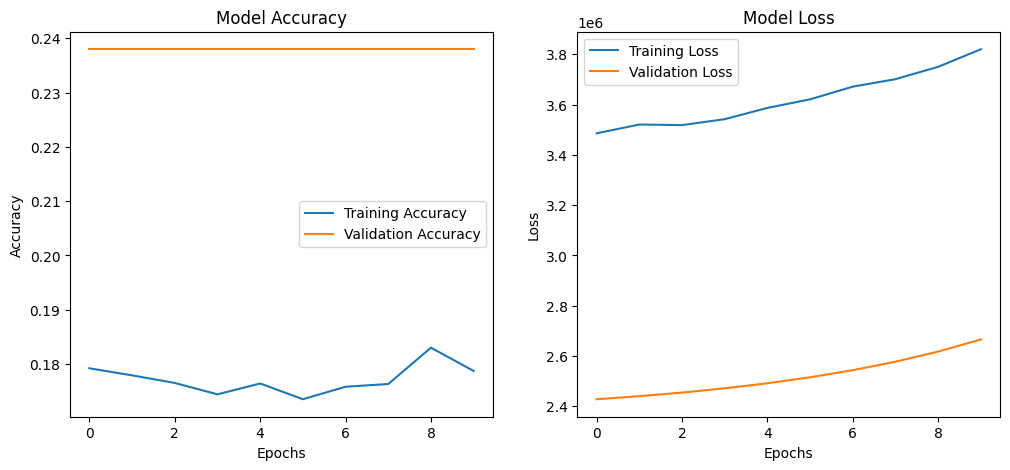

In [85]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [86]:
predictions = model.predict(test_pca_reshaped)
predicted_labels = tf.argmax(predictions, axis=1).numpy()  # Convert predictions to class indices
true_labels = tf.argmax(test_labels_indices, axis=1).numpy()  # Get true class indices


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


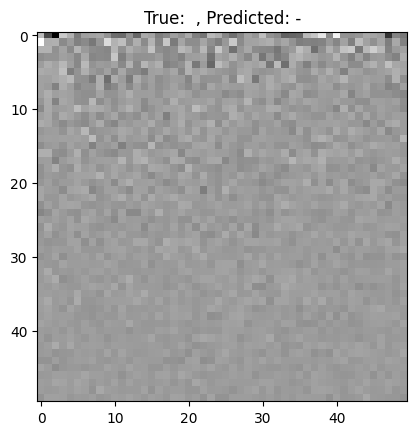

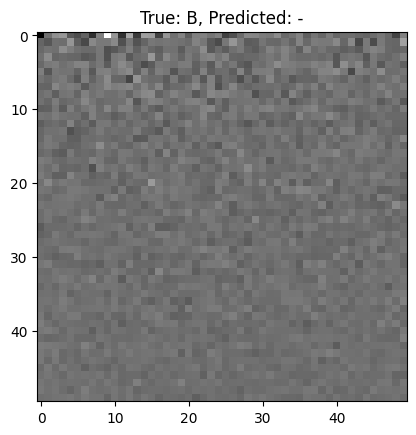

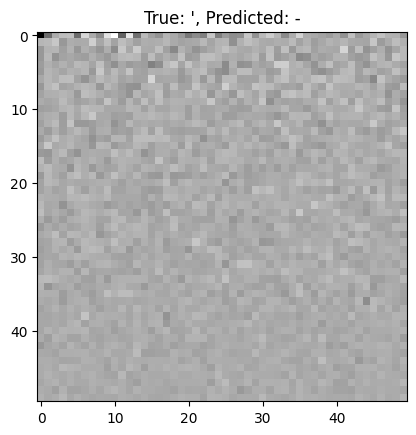

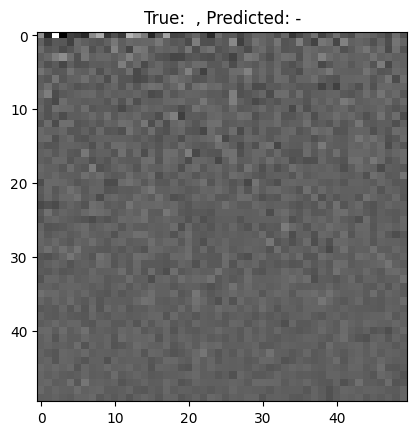

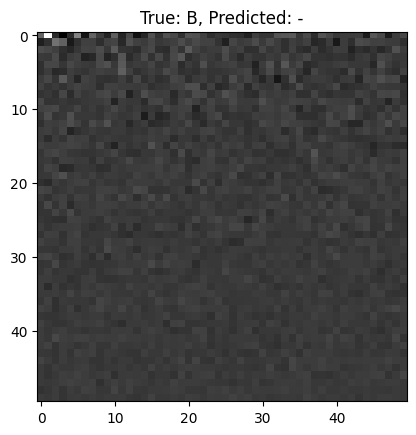

In [87]:
misclassified_indices = [i for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)) if true != pred]

for idx in misclassified_indices[:5]:  # Show first 5 misclassified examples
    plt.imshow(test_pca_reshaped[idx].reshape(50, 50), cmap='gray')  # Reshape if necessary
    plt.title(f"True: {lb.classes_[true_labels[idx]]}, Predicted: {lb.classes_[predicted_labels[idx]]}")
    plt.show()

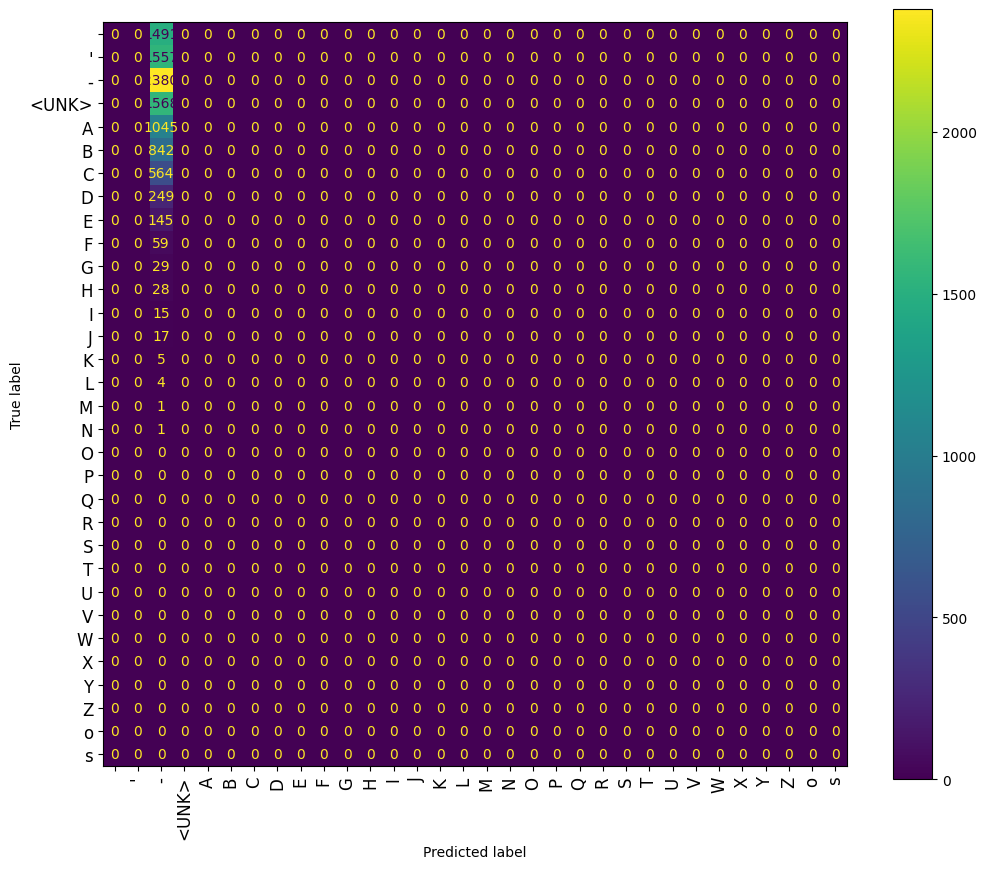

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(len(lb.classes_)))

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot(cmap='viridis', xticks_rotation='vertical', ax=ax, colorbar=True)

# Customize font size for labels
ax.tick_params(axis='both', labelsize=12)  # Increase font size for ticks
for texts in disp.text_.ravel():  # Increase font size of annotations inside the matrix
    if texts is not None:
        texts.set_fontsize(10)

plt.show()
